# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Описание данных



**Признаки**


DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

**Целевой признак** Price — цена (евро)

In [1]:
#импортируем нужные библиотеки для работы

import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMRegressor

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     GridSearchCV,
                                     RepeatedStratifiedKFold)

from sklearn.preprocessing import (StandardScaler,
                                  OrdinalEncoder)

from sklearn.metrics import mean_squared_error

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from tqdm import tqdm




In [4]:
#прочитаем и посмотрим данные
data = pd.read_csv('C:/Users/Lerusik/Documents/datasets/autos.csv')
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


**Много пропусков:**

VehicleType - тип автомобильного кузова

Gearbox — тип коробки передач

Model — модель автомобиля

FuelType — модель топлива

Repaired — была машина в ремонте или нет

Очевидно, что есть **выбросы**, надо проверять каждый признак

**Ненужные признаки:**

DateCrawled — дата скачивания анкеты из базы

PostalCode — почтовый индекс владельца анкеты (пользователя)

**Сомнительные признаки:**
 

RegistrationMonth — месяц регистрации автомобиля

DateCreated — дата создания анкеты

LastSeen — дата последней активности пользователя

In [5]:
#удалим ненужные признаки
data.drop(columns=['DateCrawled','PostalCode','RegistrationMonth','LastSeen'], axis= 1 , inplace= True )

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
 10  DateCreated       354369 non-null  object
 11  NumberOfPictures  354369 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 32.4+ MB


In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,NumberOfPictures
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.0
mean,4416.656776,2004.234448,110.094337,128211.172535,0.0
std,4514.158514,90.227958,189.850405,37905.341530,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,0.0


Посмотрим выбросы, заполним пропуски для каждого признака:

#### Price

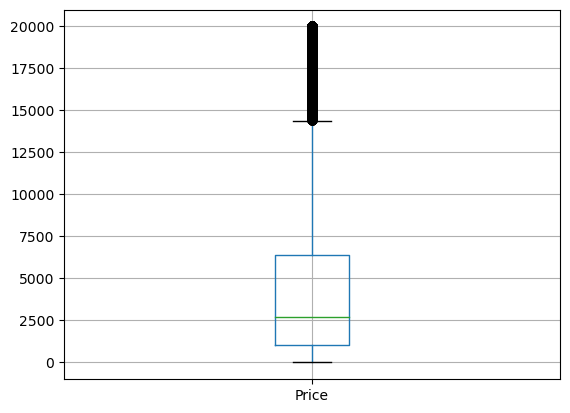

In [8]:
data.boxplot(column=['Price'])
plt.show()

In [9]:
data['Price'].sort_values().head(1000)

205926    0
204097    0
204099    0
204104    0
62604     0
         ..
125843    0
125884    0
342091    0
125839    0
234531    0
Name: Price, Length: 1000, dtype: int64

In [10]:
data = data.query('Price > 0')

Естественно есть завышенные цены. Есть и нулевые. Поскольку нам такие данные не нужны, а заполнить их примерным числом не представляется логичным, эти данные придется удалить

In [11]:
np.percentile(data["Price"], 2.5)

200.0

Если переоцененные машины могут быть, то слишком дешевые скорее всего будут мешать нашей модели. Уберу 2,5% нижних значений

In [12]:
data = data.query('Price > 200')

####  VehicleType

In [13]:
#заменим пропуски 
data['VehicleType'] = data['VehicleType'].fillna('unknow')

#удалим пропуски
#data = data.dropna(subset=['VehicleType'])

####  RegistrationYear

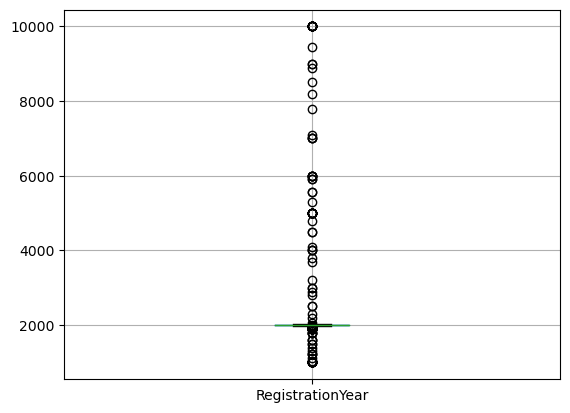

In [14]:
data.boxplot(column=['RegistrationYear'])
plt.show()

Очевидно, что год регистрации не может превышать дату скачивания. Обрежем данные

In [15]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], utc=True)
data['DateCreatedYear'] = data['DateCreated'].dt.year

In [16]:
data['DateCreatedYear'].max()

2016

In [17]:
data = data.query('RegistrationYear < 2016 & RegistrationYear > 1900')

In [18]:
#удалим ненужные признаки
data.drop(columns=['DateCreated','DateCreatedYear'], axis= 1 , inplace= True )

####  Gearbox

In [19]:
h = data['Gearbox'].hist()
fig = h.get_figure()

In [20]:
#заменим пропуски чащевстречающимся значением
data['Gearbox'] = data['Gearbox'].fillna('manual')

### Power

In [21]:
col = 'Power'

print(f"""Уникальные значения в столбце {col}: {data[col].sort_values().unique()}""")
    

Уникальные значения в столбце Power: [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154   155
   156   157  

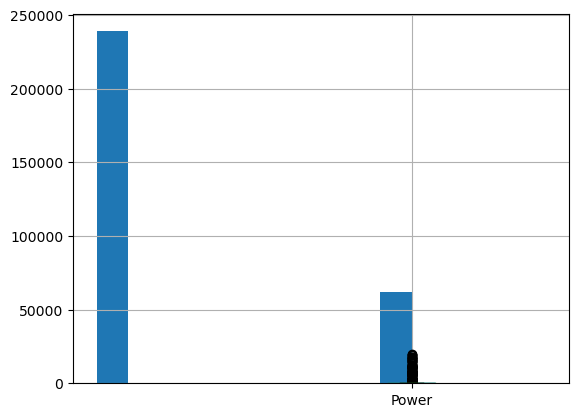

In [22]:
data.boxplot(column=['Power'])
plt.show()

In [23]:
data = data.query('Power < 2028 & Power > 50') #в инетике посмотрела максимальную мощность машины

### Model

In [24]:
data.value_counts('Model')

Model
golf                  23463
other                 19300
3er                   17053
a4                     8678
astra                  8645
                      ...  
i3                        5
elefantino                4
serie_3                   3
range_rover_evoque        2
rangerover                2
Length: 248, dtype: int64

In [25]:
#заменим маловстречающиеся на other

#если меньше 500 машин, то сделаем их "другие"
new = data['Model'].value_counts()
new = new[new<500].index
another_list = []
for i in list(data['Model'].unique()):
    if i in new:
        another_list.append(i)


data['Model'] = data['Model'].replace(another_list, 'other')

#заменим пропуски на unknow
data['Model'] = data['Model'].fillna('other')



### Kilometer

In [26]:
h = data['Kilometer'].hist(bins=20)
fig = h.get_figure()

В целом зависимость похожа на экспоненциальную, это значит, что в целом выбросов нет, теория совпадает с реальностью, машин с большим пробегом больше на подобных площадках для продажи

### FuelType

In [27]:
h = data['FuelType'].hist()
fig = h.get_figure()

In [28]:
# редкие объединим
data['FuelType'] = data['FuelType'].replace('hybrid','other')
data['FuelType'] = data['FuelType'].replace('electric','other')
data['FuelType'] = data['FuelType'].replace('cng','other')
data['FuelType'] = data['FuelType'].replace('lpg','other')

In [29]:
data['FuelType'] = data['FuelType'].fillna('unknow')

In [30]:
data.loc[data['FuelType'] == 'unknow']

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,NumberOfPictures
9,999,small,1998,manual,101,golf,150000,unknow,volkswagen,NaN,0
13,2500,wagon,2004,manual,131,passat,150000,unknow,volkswagen,no,0
36,1600,other,1991,manual,75,other,70000,unknow,opel,NaN,0
41,7500,sedan,2002,auto,306,e_klasse,150000,unknow,mercedes_benz,NaN,0
71,2300,unknow,1997,manual,150,5er,150000,unknow,bmw,no,0
...,...,...,...,...,...,...,...,...,...,...,...
354326,1300,small,1999,manual,75,2_reihe,125000,unknow,peugeot,NaN,0
354327,2999,wagon,2004,manual,234,vectra,100000,unknow,opel,NaN,0
354329,350,small,1996,manual,65,punto,150000,unknow,fiat,NaN,0
354339,3850,convertible,2006,manual,108,2_reihe,125000,unknow,peugeot,no,0


Сложно сказать, какой параметр может коррелировать  с типом топлива. В данных также наблюдаются различные годы, марки и мощности. Поэтому заполню наиболее частовстречающимися значениями

In [31]:
data['FuelType'] = data['FuelType'].replace('unknow','petrol')

### Brand

In [32]:
data.value_counts('Brand')

Brand
volkswagen        57878
bmw               31672
opel              29491
mercedes_benz     26885
audi              25064
ford              18862
renault           12942
peugeot            8859
fiat               6864
seat               5012
skoda              4835
mazda              4517
citroen            3986
toyota             3942
nissan             3821
smart              3449
hyundai            3030
mini               2918
volvo              2761
mitsubishi         2360
honda              2289
kia                2039
alfa_romeo         1908
suzuki             1811
sonstige_autos     1487
chevrolet          1435
chrysler           1137
dacia               787
porsche             619
subaru              609
jeep                571
daihatsu            509
saab                464
land_rover          461
jaguar              436
daewoo              376
lancia              348
rover               333
lada                154
trabant               5
dtype: int64

Всё окей

### Repaired

In [33]:
h = data['Repaired'].hist()
fig = h.get_figure()

In [34]:
data_repaired = data.loc[data['Repaired'] == 'yes']

In [35]:
data_repaired['RegistrationYear'].value_counts().sort_values(ascending=False)

1999    2325
2000    2186
2001    1966
1998    1893
2003    1712
        ... 
1964       1
1965       1
1955       1
1945       1
1937       1
Name: RegistrationYear, Length: 62, dtype: int64

In [36]:
pd.pivot_table(data_repaired,
               index=["RegistrationYear"],
               values=["Kilometer"], aggfunc=['median','count']).sort_values(by=['RegistrationYear'],ascending=False)

,median,count
,Kilometer,Kilometer
RegistrationYear,,
2015,10000,52
2014,30000,86
2013,50000,120
2012,60000,236
2011,90000,358
...,...,...
1957,150000,1
1955,100000,1


In [37]:
data['Repaired'].isnull().sum()/len(data['Repaired'])

0.13263832215104396

Интуитивно кажется, что пропуски оставляли, потому что не хотели, чтобы знали, что машина была в ремонте. 15% пропусков заполню значением "да"

In [38]:
data['Repaired'] = data['Repaired'].fillna('yes')

### NumberOfPictures

In [39]:
h = data['NumberOfPictures'].hist()
fig = h.get_figure()

In [40]:
data['NumberOfPictures'].unique()

array([0], dtype=int64)

In [41]:
#удалим пустой столбец
data.drop(columns=['NumberOfPictures'], axis= 1 , inplace= True )

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276926 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             276926 non-null  int64 
 1   VehicleType       276926 non-null  object
 2   RegistrationYear  276926 non-null  int64 
 3   Gearbox           276926 non-null  object
 4   Power             276926 non-null  int64 
 5   Model             276926 non-null  object
 6   Kilometer         276926 non-null  int64 
 7   FuelType          276926 non-null  object
 8   Brand             276926 non-null  object
 9   Repaired          276926 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.2+ MB


In [43]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,276926.000000,276926.000000,276926.000000,276926.000000
mean,5082.635242,2002.834291,125.033800,128209.702231
std,4635.523980,6.049586,63.462361,36617.119212
min,202.000000,1910.000000,51.000000,5000.000000
25%,1500.000000,1999.000000,85.000000,125000.000000
50%,3499.000000,2003.000000,116.000000,150000.000000
75%,7350.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2015.000000,2018.000000,150000.000000


Данные готовы к работе: проверены и заполнены пропуски, экстремальные значения и удалены лишние признаки

## Подготовка выборок для обучения моделей

In [44]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

In [45]:
#разделим на целевой признак 
features_train = data_train.drop(['Price'],axis=1)
target_train = data_train['Price'] #целевой признак

features_test = data_test.drop(['Price'],axis=1)
target_test = data_test['Price']

In [46]:
#стандартизируем

numeric = [ 'RegistrationYear', 'Power', 'Kilometer']

pd.options.mode.chained_assignment = None 

scaler = StandardScaler()  


scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [47]:
categorical_feature = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

In [48]:
encoder = OrdinalEncoder()
encoder.fit(features_train[categorical_feature])

features_train[categorical_feature] = encoder.transform(features_train[categorical_feature] )
features_test[categorical_feature] = encoder.transform(features_test[categorical_feature] )



## Обучение моделей


### Подбор параметров для бустинга

In [49]:
%%time 
warnings.filterwarnings("ignore") 

model = LGBMRegressor()

params = {'n_estimators': range (80, 201, 20), #range (20, 200, 10),
          'max_depth': range (10, 51, 5), #range (1,100, 5),
          'random_state': [42]} #'learning_rate': range (),

grid_1 = GridSearchCV(model, params, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)
grid_1.fit(features_train, target_train)

print(grid_1.best_params_)
grid_1.best_score_

{'max_depth': 15, 'n_estimators': 200, 'random_state': 42}
Wall time: 4min 34s


-1632.2229934821328

### Подбор параметров для случайного леса

In [50]:
%%time 
warnings.filterwarnings("ignore") 

model = RandomForestRegressor()

params = {'n_estimators': range (80, 201, 20), #range (20, 200, 10),
          'max_depth': range (10, 26, 5), #range (1,100, 5),
          'random_state': [42]} 

grid_2 = GridSearchCV(model, params, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)
grid_2.fit(features_train, target_train)

print(grid_2.best_params_)
grid_2.best_score_

{'max_depth': 20, 'n_estimators': 200, 'random_state': 42}
Wall time: 55min 52s


-1597.2661644356162

#### Выводы по выбору модели



Было проверено 2 модели: градиентный бустинг и случайный лес. Для данной задачи необходима скорость, которая гораздо лучше в первом варианте, и качество, которое достигается в обоих случаях: метрика RMSE порядка 1600. В случайном лесе метрика немного лучше, но это не сравнится со временем обучния, которое у случайного леса больше в 11 раз даже на меньших параметрах.Поэтому для тестирования выбрана модель бустинга

## Тестирование лучшей модели - LGBMRegressor


In [51]:
%%time 
expected_y  = target_test
predicted_y = grid_1.predict(features_test)
    
        
rmse = mean_squared_error(expected_y,predicted_y, squared=False)
print('RMSE на тестовой выборке', rmse )


RMSE на тестовой выборке 1633.5135772974231
Wall time: 252 ms


## Выводы

Была проведена работа по вычищению данных: были выявлены выбросы, аномалии, пропуски, после чего они были обработаны для дальнейшей работы с моделями машинного обучения. Данные были закодированы, стандартизированы и разделены на тренировочную и тестовую выборки. 

В разделе с обучением моделей были выбраны модели градиентного бустинга и случайного леса. Поскольку заказчику важны все параметры: точность, время и качество, после подбора гиперпараметров для каждой модели была выбрана модель градиентого бустинга, поскольку она даёт хорошее показание метрики RMSE и относительно быстро обучается. 

Таким образом для тестовой выборки время предсказания составило:252 секунды и значение метрики RMSE: 1633